In [1]:
import numpy as np
import matplotlib
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import pylab
from decimal import *
from astropy.io import fits
from jovispec import abcio
import chopstacks as cs
import sklearn.linear_model as lm
from jovispec import abcweight as aw
from jovispec import plotspec as ps
from jovispec import logspace as ls
import pkg_resources



In [6]:
jupiter_data = pkg_resources.resource_filename("jovispec", "jupiter_data")

#red 
rlambc, rspecc, rheadc=abcio.read_qfits("06033",jupiter_data,ext="q")
rlambw, rspecw, rheadw=abcio.read_qfits("06047",jupiter_data,ext="q")
rlambe, rspece, rheade=abcio.read_qfits("06049",jupiter_data,ext="q")

#blue
#rlambc, rspecc, rheadc=abcio.read_qfits("06034",jupiter_data,ext="q")
#rlambw, rspecw, rheadw=abcio.read_qfits("06048",jupiter_data,ext="q")
#rlambe, rspece, rheade=abcio.read_qfits("06050",jupiter_data,ext="q")

In [7]:
def yrenorm(spec):
    spec=spec/np.median(spec[spec>0.0])
    return spec
rspecc=yrenorm(rspecc)
rspece=yrenorm(rspece)
rspecw=yrenorm(rspecw)


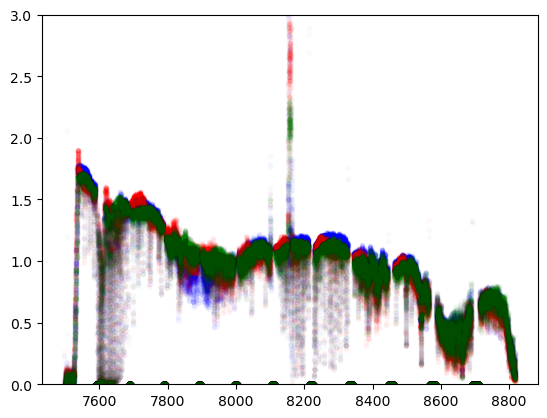

In [8]:
# obs data used in this analysis 
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(rlambc,rspecc,".",c="blue",alpha=0.02)
ax.plot(rlambe,rspece,".",c="red",alpha=0.02)
ax.plot(rlambw,rspecw,".",c="green",alpha=0.02)

#pylab.xlim(8000,8700)
pylab.ylim(0,3)
#plt.savefig("blue.png")
plt.savefig("red.png")
plt.show()

In [9]:
a=np.array([1,2,3,4,5,7,8,9])
print np.hstack([a[1:]-a[:-1],[6]])

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (645328843.py, line 2)

In [10]:
tstart=7540.0
tend=8817.0
mask=(rspece>0.0)
gap=(rlambe>8150)*(rlambe<8165)
gap2=(rlambe>8098)*(rlambe<8103)
uplim=10.0
dx=rlambe[2]-rlambe[1]
mask=mask*(rlambe>tstart)*(~gap)*(~gap2)*(rspece<uplim)



interval=20.0
overlap=0.0

mrlambe=rlambe[mask]
mrspece=rspece[mask]
mrspecw=rspecw[mask]
mrspecc=rspecc[mask]

tnorme=np.median(mrspece)
tnormw=np.median(mrspecw)
tnormc=np.median(mrspecc)

mrspece=mrspece/tnorme
mrspecw=mrspecw/tnormw
mrspecc=mrspecc/tnormc


dlambe=np.hstack([mrlambe[1:]-mrlambe[:-1],[dx]])
newmask=(dlambe<10*dx)
mrlambe=mrlambe[newmask]
##mrlambc=mrlambc[newmask]
##mrlambw=mrlambw[newmask]
mrspece=mrspece[newmask]
mrspecc=mrspecc[newmask]
mrspecw=mrspecw[newmask]

In [11]:
def onclip(event):
    
    ind=np.searchsorted(mrlambe,event.xdata)
    plt.title("You clicked index="+str(ind))
    ax.plot([mrlambe[ind]],mrspece[[ind]],"x",color="green")
    fig.canvas.draw()

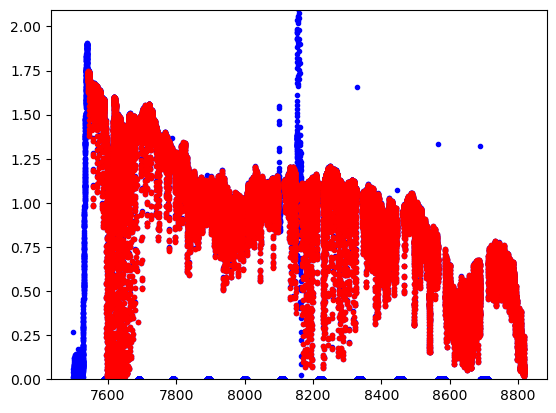

In [12]:
# obs data used in this analysis 
fig=plt.figure()
ax=fig.add_subplot(111)
#ax.plot(rlambe,dlambe,".")
ax.plot(rlambe,rspece,".",c="blue")
ax.plot(mrlambe,mrspece,".",c="red")
#pylab.xlim(8000,8700)
pylab.ylim(0,1.2*np.max(mrspece))
#ax.plot(lambe[ks:ke],spece[ks:ke])
#cid = fig.canvas.mpl_connect('button_press_event', onclip)
plt.show()

In [14]:
mrlambe_f = np.array([float(d) for d in mrlambe])

n=int((tend-tstart)/(interval-overlap))
qs=np.array(range(0,n))*(interval-overlap)+tstart
qe=qs+interval
jqs=np.digitize(qs,mrlambe_f)
jqe=np.digitize(qe,mrlambe_f)
nseg=len(qs)

In [15]:
nseg

63

In [18]:
R=300000
vr=-11  ### just use vrot ~ 11 km/s
deltav=np.array([[0,vr,2*vr],[0,0,0],[0,-vr,-2*vr]])
P=3
Q=3

aefplt=[]
aefplp=[]
aefpls=[]
ala=[]
anorme=[]
anormw=[]
anormc=[]
awav=[]
amspexe=[]
amspexc=[]
amspexw=[]

for iseg in range(0,nseg):
#for iseg in range(26,27):
# resampling and use new coordinates ( c log lambda - log f)

    #logspace
    ks1=jqs[iseg]
    ke1=jqe[iseg]
    wav=mrlambe_f[ks1:ke1]
    wavw=cs.buildwall(wav)

    hx, hxw, hfe, mspexe, norme=ls.setls(wav,wavw,mrspece[ks1:ke1],R)
    hx, hxw, hfw, mspexw, normw=ls.setls(wav,wavw,mrspecw[ks1:ke1],R)
    hx, hxw, hfc, mspexc, normc=ls.setls(wav,wavw,mrspecc[ks1:ke1],R)


    
    dv=hx[1]-hx[0]
    
    #compute weight
    K=len(hx)
    Wij=aw.generate_abc_design_matrix(deltav,K)
    fobs=np.hstack([hfe,hfc,hfw]) 
    
    try:
        #Solve the linear model
        clf = lm.RidgeCV(alphas = [1.e-1,3.e-1,1.e0,3.e0])
        clf.fit(Wij,fobs) 
        print("Ridge lambda=",clf.alpha_)
        cestr=clf.coef_
        interr=clf.intercept_
        cestqr = np.array_split(cestr,Q)
    
        clf = lm.LassoCV(alphas = [1.e-2,3.e-2,1.e-1,3.e-1,1.e0])
        clf.fit(Wij,fobs) 
        print("LASSO lambda=",clf.alpha_)
        cestl=clf.coef_
        interl=clf.intercept_
        cestql = np.array_split(cestl,Q)
    
    #recover
        c=299792
        la=np.exp(hx/c) 

    #compute predictions
        renorm=np.hstack([la,la,la])
        fprer=np.exp((np.dot(Wij,cestr)+interr)/renorm)
        fpr=np.array_split(fprer,P)
        fprel=np.exp((np.dot(Wij,cestl)+interl)/renorm)
        fpl=np.array_split(fprel,P)
    
    #ps.plot_prediction3(wav,mspexe,mspexc,mspexw,la,fpl,fpr)
    
    #compute the prediction for each component (LASSO)
        renorm=np.hstack([la,la,la])
        fprelt=np.exp((np.dot(Wij,np.hstack([cestql[0],np.zeros(2*K)]))+interl)/renorm) #telluric
        efplt=np.array_split(fprelt,P)
    
        fprelp=np.exp((np.dot(Wij,np.hstack([np.zeros(K),cestql[1],np.zeros(K)]))+interl)/renorm) #planet
        efplp=np.array_split(fprelp,P)
    
        fprels=np.exp((np.dot(Wij,np.hstack([np.zeros(2*K),cestql[2]]))+interl)/renorm)#stellar
        efpls=np.array_split(fprels,P)

    #plot
    #ps.plot_each3(wav,mspexe,mspexc,mspexw,la,efplt,efplp,efpls)

    #append
        ala.append(la)
        aefplt.append(fprelt)
        aefplp.append(fprelp)
        aefpls.append(fprels)

        anorme.append(norme)
        anormw.append(normw)
        anormc.append(normc)
        awav.append(wav)
        amspexe.append(mspexe)
        amspexw.append(mspexw)
        amspexc.append(mspexc)
    except:
        print("ERROR at i=",i)

Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.03
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.1
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Re

/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e+06, tolerance: 1.665e+06
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data

/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.786e+05, tolerance: 7.358e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+05, tolerance: 7.508e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 3.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e+05, tolerance: 7.499e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.215e+05, tolerance: 7.234e+04
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 3.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+06, tolerance: 6.029e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e+05, tolerance: 5.989e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 1.0
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 3.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.384e+05, tolerance: 9.701e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+05, tolerance: 8.699e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.594e+05, tolerance: 1.523e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e+05, tolerance: 1.487e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e+05, tolerance: 1.313e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.251e+05, tolerance: 1.582e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e+05, tolerance: 7.472e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.705e+04, tolerance: 8.228e+04
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data

/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+05, tolerance: 8.892e+04
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e+05, tolerance: 1.225e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.489e+05, tolerance: 1.284e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.264e+05, tolerance: 3.179e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.966e+05, tolerance: 3.905e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e+05, tolerance: 2.230e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.1


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.475e+04, tolerance: 1.829e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.532e+04, tolerance: 2.337e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 1.0
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.1
LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e+05, tolerance: 9.208e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.402e+04, tolerance: 7.328e+04
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0
LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.1


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.901e+05, tolerance: 7.706e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+04, tolerance: 2.973e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.821e+04, tolerance: 2.973e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 1.0
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.727e+05, tolerance: 3.081e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.241e+05, tolerance: 3.140e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e+06, tolerance: 6.611e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.559e+05, tolerance: 7.216e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+06, tolerance: 1.036e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+06, tolerance: 1.000e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.434e+06, tolerance: 1.120e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e+06, tolerance: 1.305e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 1.0
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+06, tolerance: 2.158e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.496e+06, tolerance: 2.846e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.1


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.755e+05, tolerance: 4.266e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.101e+05, tolerance: 4.527e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.948e+04, tolerance: 3.840e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.766e+05, tolerance: 4.297e+04
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 1.0
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 0.3


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.181e+05, tolerance: 1.151e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.1
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e+05, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(


LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e+05, tolerance: 1.498e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.930e+05, tolerance: 1.690e+05
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3
Reset master data (hf) to zero.
Reset master data (hf) to zero.
Reset master data (hf) to zero.
I used 4 for loops!! Please modify my code anyone!!!
0 / 3 - 0 / 3
0 / 3 - 1 / 3
0 / 3 - 2 / 3
1 / 3 - 0 / 3
1 / 3 - 1 / 3
1 / 3 - 2 / 3
2 / 3 - 0 / 3
2 / 3 - 1 / 3
2 / 3 - 2 / 3
Ridge lambda= 1.0


/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.974e+06, tolerance: 1.079e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e+06, tolerance: 1.158e+06
  model = cd_fast.enet_coordinate_descent(
/home/kawahara/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LASSO lambda= 0.3


In [19]:
np.shape(awav),np.shape(amspexe[0])

/home/kawahara/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


((63,), (902,))

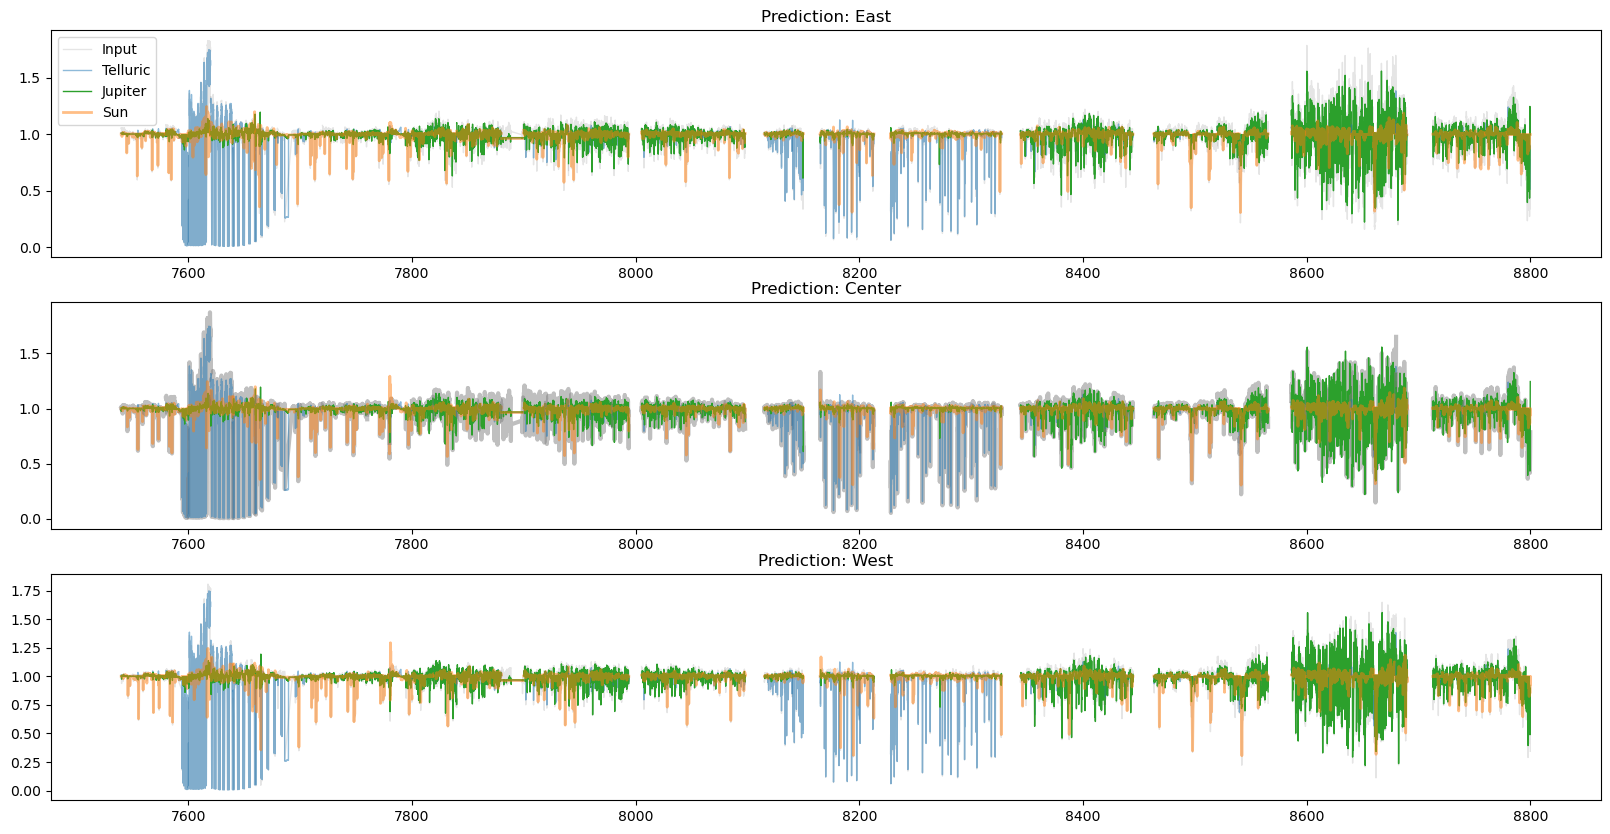

In [37]:
fig = plt.figure(figsize=(20,10))
ax1=fig.add_subplot(311)
ax2=fig.add_subplot(312)
ax3=fig.add_subplot(313)
    
for i in range(0,nseg):
    la=ala[i]
    efplt=np.array_split(aefplt[i],P)
    efplp=np.array_split(aefplp[i],P)
    efpls=np.array_split(aefpls[i],P)
    #ax.plot(la,hfe,lw=3,color="blac
    if i==0:
        ax1.plot(awav[i],amspexe[i],lw=1,alpha=0.2,color="gray",label="Input")
        ax1.plot(la,efplt[0],lw=1,alpha=0.5,color="C0",label="Telluric")
        ax1.plot(la,efplp[0],lw=1,alpha=1,color="C2",label="Jupiter")
        ax1.plot(la,efpls[0],lw=2,alpha=0.5,color="C1",label="Sun")
        ax1.set_title("Prediction: East")
        ax1.legend()
    else:
        ax1.plot(awav[i],amspexe[i],lw=1,alpha=0.2,color="gray")
        ax1.plot(la,efplt[0],lw=1,alpha=0.5,color="C0")
        ax1.plot(la,efplp[0],lw=1,alpha=1,color="C2")
        ax1.plot(la,efpls[0],lw=2,alpha=0.5,color="C1")
    ax2.plot(awav[i],amspexc[i],lw=3,alpha=0.5,color="gray")
    ax2.plot(la,efplt[1],lw=1,alpha=0.5,color="C0")
    ax2.plot(la,efplp[1],lw=1,alpha=1,color="C2")
    ax2.plot(la,efpls[1],lw=2,alpha=0.5,color="C1")
    if i==0:
        ax2.set_title("Prediction: Center")
    ax3.plot(awav[i],amspexw[i],lw=1,alpha=0.2,color="gray")
    #ax.plot(la,hfw,lw=3,color="black",alpha=0.5)                               
    ax3.plot(la,efplt[2],lw=1,alpha=0.5,color="C0")
    ax3.plot(la,efplp[2],lw=1,alpha=1,color="C2")
    ax3.plot(la,efpls[2],lw=2,alpha=0.5,color="C1")
    if i==0:
        ax3.set_title("Prediction: West")
        
plt.savefig("jupiter.png")        
plt.show()


In [12]:
np.savez("try1.npz",[la,efplt,efplp,efpls,awav,amspexw,amspexe,amspexc])